In [ ]:
#making sure Python environment has the libraries that need before actually import and use them in code.
!pip install transformers
!pip install datasets
!pip install seaborn}


ERROR: Invalid requirement: 'seaborn}': Expected end or semicolon (after name and no valid version specifier)
    seaborn}
           ^


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()



Saving player_performance_dataset.csv to player_performance_dataset.csv


In [ ]:
import pandas as pd
df = pd.read_csv('player_performance_dataset.csv')
df.head()


,Player,Age,Position,Current_League,New_League,Goals_Last_League,Assists_Last_League,Rating_Last_League,Goals_New_League,Assists_New_League,Rating_New_League
0,Player_1,28,Goalkeeper,EPL,Ligue 1,1.5,6.0,7.36,1.3,6.8,6.90
1,Player_2,22,Forward,Bundesliga,Serie A,3.3,3.2,6.24,3.1,1.7,6.74
2,Player_3,20,Goalkeeper,Serie A,EPL,18.4,6.4,6.13,17.6,5.8,5.84
3,Player_4,21,Forward,Serie A,La Liga,16.2,8.0,7.50,17.1,6.7,7.50
4,Player_5,33,Forward,La Liga,Serie A,10.6,7.1,6.81,11.9,6.6,7.13


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
#check for missing values:
df.isnull().sum()


,0
Player,0
Age,0
Position,0
Current_League,0
New_League,0
Goals_Last_League,0
Assists_Last_League,0
Rating_Last_League,0
Goals_New_League,0
Assists_New_League,0


In [ ]:
df.describe(include='all')  # Includes numeric columns
df.info()                   # Data types and non-null counts


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Player               1000 non-null   object 
 1   Age                  1000 non-null   int64  
 2   Position             1000 non-null   object 
 3   Current_League       1000 non-null   object 
 4   New_League           1000 non-null   object 
 5   Goals_Last_League    1000 non-null   float64
 6   Assists_Last_League  1000 non-null   float64
 7   Rating_Last_League   1000 non-null   float64
 8   Goals_New_League     1000 non-null   float64
 9   Assists_New_League   1000 non-null   float64
 10  Rating_New_League    1000 non-null   float64
dtypes: float64(6), int64(1), object(4)
memory usage: 86.1+ KB


<Axes: >

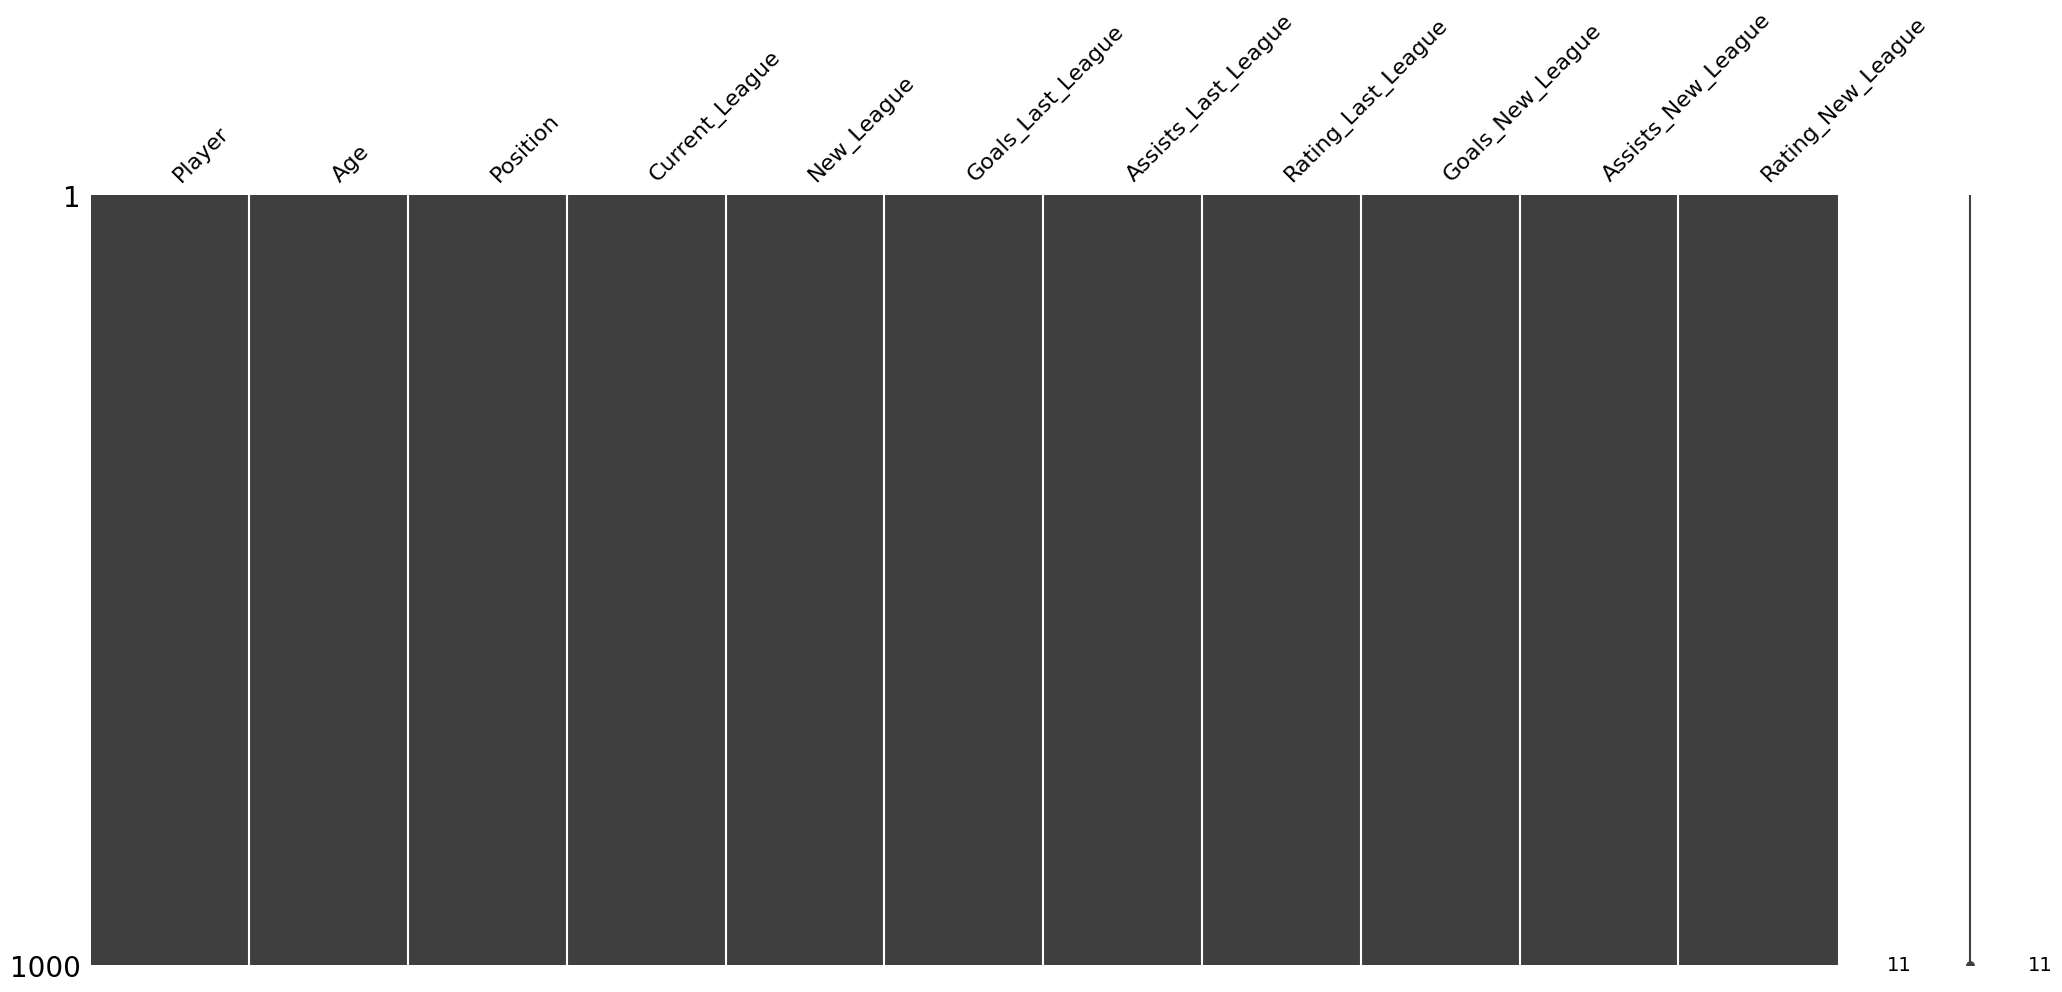

In [ ]:
df.isnull().sum()

import missingno as msno
msno.matrix(df)


In [ ]:
df['delta_goals'] = df['Goals_New_League'] - df['Goals_Last_League']
df['delta_assists'] = df['Assists_New_League'] - df['Assists_Last_League']
df['delta_rating'] = df['Rating_New_League'] - df['Rating_Last_League']


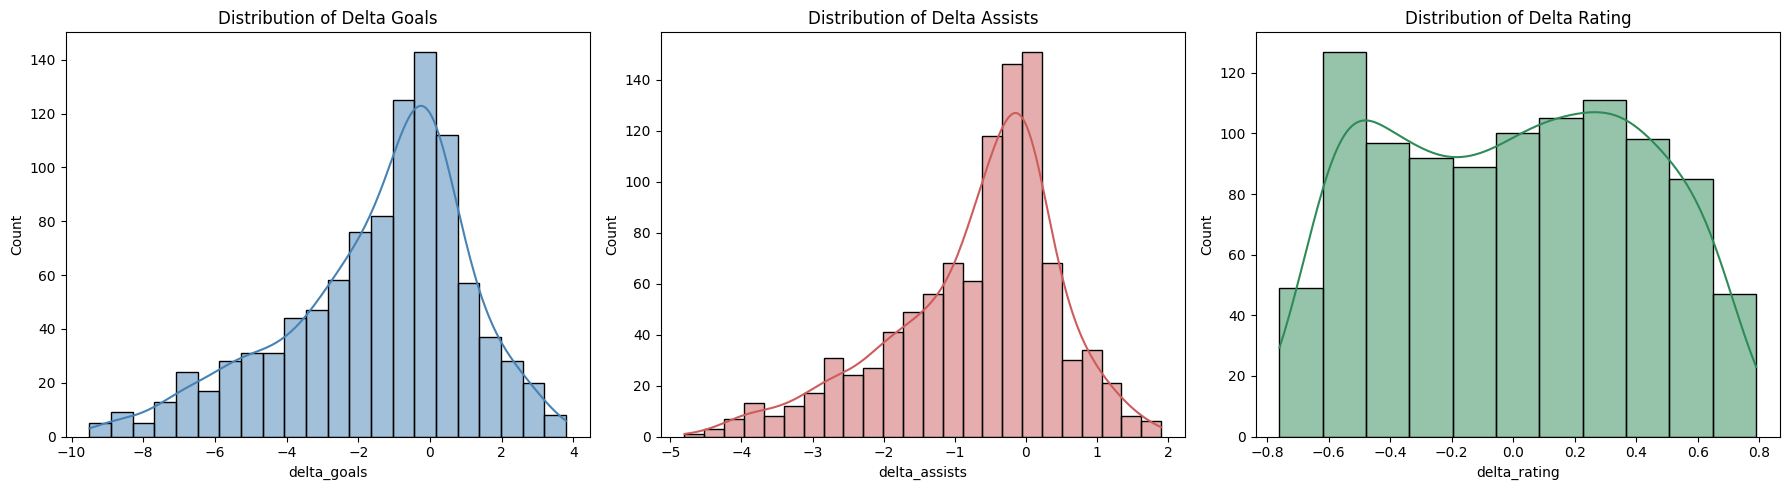

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df['delta_goals'], kde=True, ax=axes[0], color='steelblue')
axes[0].set_title('Distribution of Delta Goals')

sns.histplot(df['delta_assists'], kde=True, ax=axes[1], color='indianred')
axes[1].set_title('Distribution of Delta Assists')

sns.histplot(df['delta_rating'], kde=True, ax=axes[2], color='seagreen')
axes[2].set_title('Distribution of Delta Rating')

plt.tight_layout()


Text(0.5, 1.0, 'Change in Rating by Position')

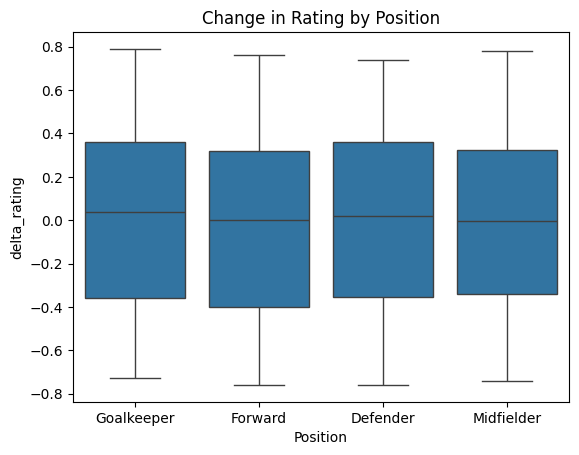

In [ ]:
sns.boxplot(x='Position', y='delta_rating', data=df)
plt.title('Change in Rating by Position')


In [ ]:
df.groupby('Position')[['delta_goals', 'delta_assists', 'delta_rating']].mean().sort_values(by='delta_rating')


,delta_goals,delta_assists,delta_rating
Position,,,
Forward,-1.571956,-0.688930,-0.024686
Midfielder,-1.665726,-0.552823,-0.007460
Defender,-1.328279,-0.800410,0.010205
Goalkeeper,-1.358228,-0.815190,0.016624


Text(0.5, 1.0, 'Rating Change by Top League Transitions')

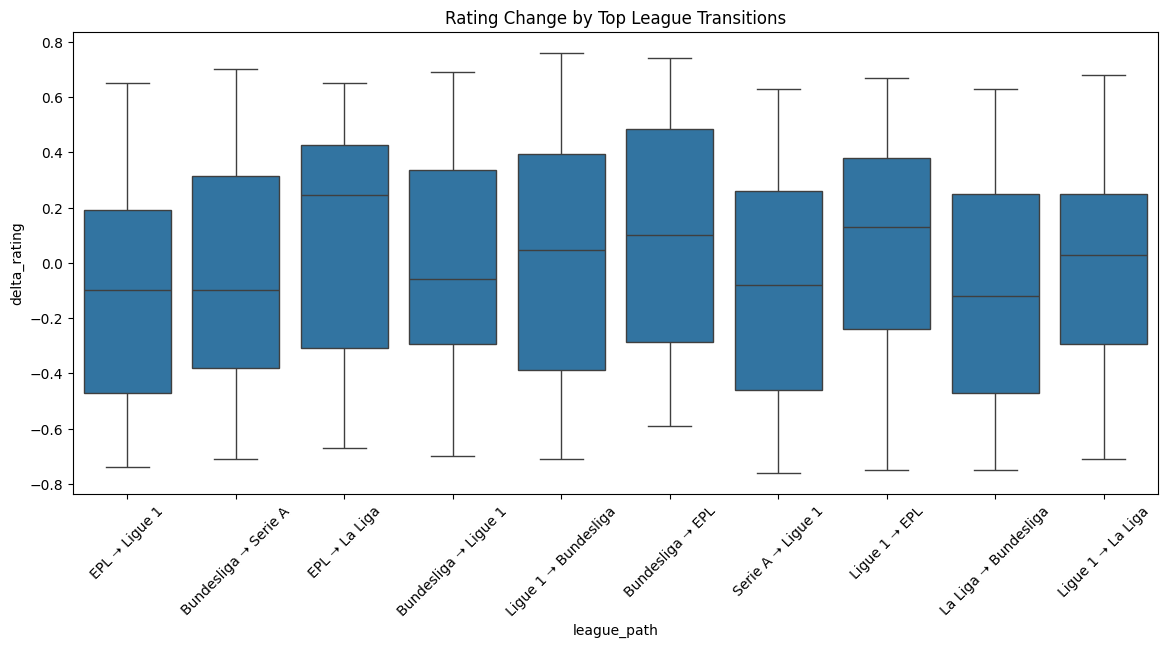

In [ ]:
df['league_path'] = df['Current_League'] + " ➝ " + df['New_League']
top_paths = df['league_path'].value_counts().head(10).index

plt.figure(figsize=(14, 6))
sns.boxplot(x='league_path', y='delta_rating', data=df[df['league_path'].isin(top_paths)])
plt.xticks(rotation=45)
plt.title('Rating Change by Top League Transitions')


Text(0.5, 1.0, 'Correlation Matrix')

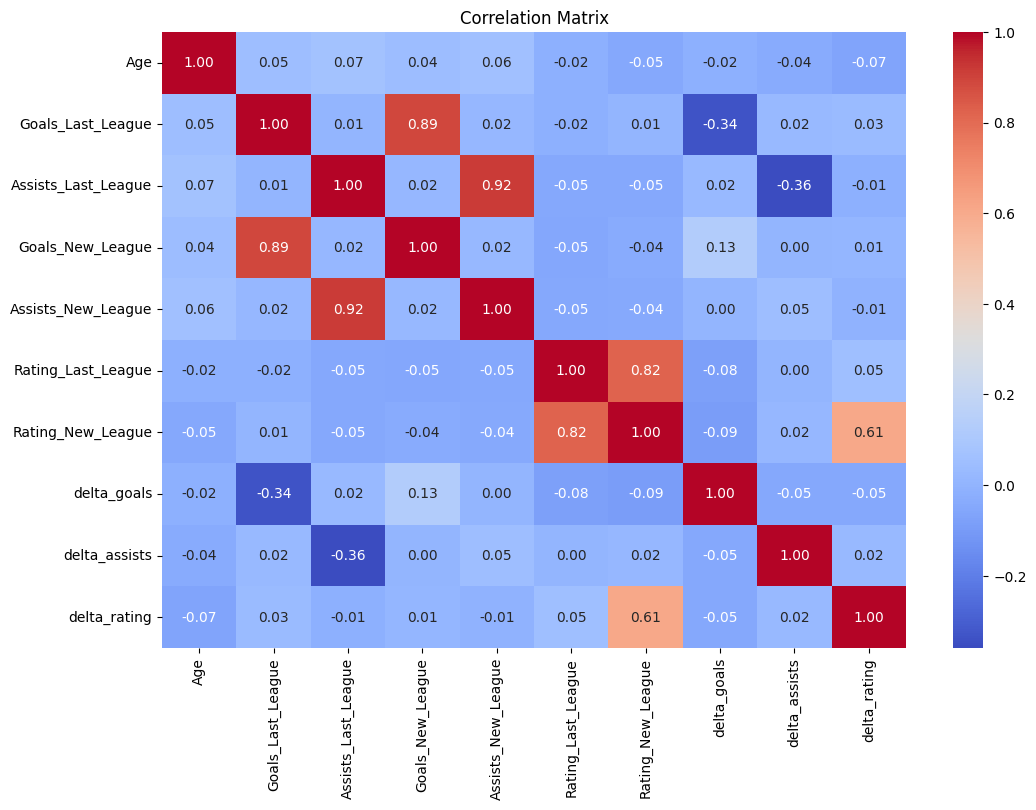

In [ ]:
corr = df[['Age', 'Goals_Last_League', 'Assists_Last_League',
           'Goals_New_League', 'Assists_New_League',
           'Rating_Last_League', 'Rating_New_League',
           'delta_goals', 'delta_assists', 'delta_rating']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")


Text(0.5, 1.0, 'Age vs. Rating Change')

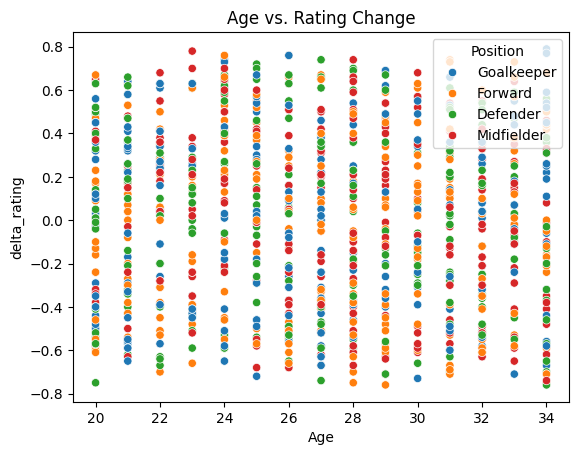

In [ ]:
sns.scatterplot(x='Age', y='delta_rating', hue='Position', data=df)
plt.title('Age vs. Rating Change')


In [ ]:
#Rating_New_League using EDA-informed features (but you can easily swap in delta_rating if you prefer):
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df = pd.read_csv('player_performance_dataset.csv')  # already uploaded


In [ ]:
#Feature Engineering
# Delta metrics based on EDA insights
df['delta_goals'] = df['Goals_New_League'] - df['Goals_Last_League']
df['delta_assists'] = df['Assists_New_League'] - df['Assists_Last_League']
df['delta_rating'] = df['Rating_New_League'] - df['Rating_Last_League']

# League transition feature
df['league_path'] = df['Current_League'] + " ➝ " + df['New_League']
df = pd.get_dummies(df, columns=['Position', 'Current_League', 'New_League', 'league_path'], drop_first=True)


In [ ]:
#Define Features and Target
features = df.drop(columns=['Player', 'Rating_New_League'])  # drop identifier and target
target = df['Rating_New_League']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [ ]:
#Scale Your Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
#Train Two Models for Comparison
# Ridge Regression
ridge = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0])
ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_test_scaled)

# Random Forest
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)  # no scaling needed for tree-based models
forest_pred = forest.predict(X_test)


In [ ]:
#Evaluate
def evaluate(y_true, y_pred, label):
    print(f"{label} → R²: {r2_score(y_true, y_pred):.3f} | MSE: {mean_squared_error(y_true, y_pred):.3f}")

evaluate(y_test, ridge_pred, "Ridge")
evaluate(y_test, forest_pred, "Random Forest")


Ridge → R²: 1.000 | MSE: 0.000
Random Forest → R²: 0.996 | MSE: 0.002


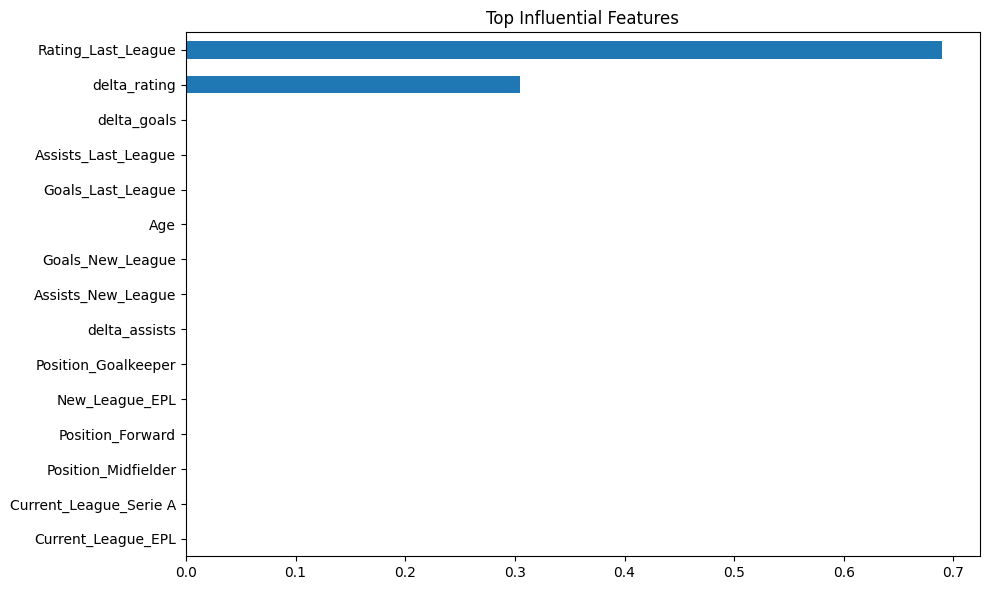

In [ ]:
#Feature Importance (From Forest)
importances = pd.Series(forest.feature_importances_, index=X_train.columns)
importances.nlargest(15).sort_values().plot(kind='barh', figsize=(10, 6))
plt.title("Top Influential Features")
plt.tight_layout()
plt.show()


In [ ]:
#Player Lookup & Stat
#Import and Load the Data
import pandas as pd
df = pd.read_csv("player_performance_dataset.csv")

In [ ]:
import ipywidgets as widgets
from IPython.display import display, Markdown

# Create a dropdown for player selection
player_dropdown = widgets.Dropdown(
    options=sorted(df['Player'].unique()),
    description='Player:',
    layout=widgets.Layout(width='50%')
)
display(player_dropdown)


Dropdown(description='Player:', layout=Layout(width='50%'), options=('Player_1', 'Player_10', 'Player_100', 'P…


### 📊 Stats for **Player_113**
**Position:** Goalkeeper  
**From:** EPL ➝ **To:** Ligue 1  
**Age:** 31  

---

#### 🎯 Performance Metrics:
- **Goals:** 10.2 ➝ 8.9 (`Δ -1.30`)
- **Assists:** 0.5 ➝ 0.6 (`Δ +0.10`)
- **Rating:** 7.46 ➝ 7.6 (`Δ +0.14`)



### 📊 Stats for **Player_110**
**Position:** Forward  
**From:** Serie A ➝ **To:** EPL  
**Age:** 28  

---

#### 🎯 Performance Metrics:
- **Goals:** 12.0 ➝ 12.2 (`Δ +0.20`)
- **Assists:** 0.7 ➝ 0.6 (`Δ -0.10`)
- **Rating:** 6.3 ➝ 6.23 (`Δ -0.07`)



### 📊 Stats for **Player_1**
**Position:** Goalkeeper  
**From:** EPL ➝ **To:** Ligue 1  
**Age:** 28  

---

#### 🎯 Performance Metrics:
- **Goals:** 1.5 ➝ 1.3 (`Δ -0.20`)
- **Assists:** 6.0 ➝ 6.8 (`Δ +0.80`)
- **Rating:** 7.36 ➝ 6.9 (`Δ -0.46`)


In [ ]:

def display_player_stats(player_name):
    player = df[df['Player'] == player_name].iloc[0]
    delta_goals = player['Goals_New_League'] - player['Goals_Last_League']
    delta_assists = player['Assists_New_League'] - player['Assists_Last_League']
    delta_rating = player['Rating_New_League'] - player['Rating_Last_League']

    display(Markdown(f"""
### 📊 Stats for **{player_name}**
**Position:** {player['Position']}
**From:** {player['Current_League']} ➝ **To:** {player['New_League']}
**Age:** {player['Age']}

---

#### 🎯 Performance Metrics:
- **Goals:** {player['Goals_Last_League']} ➝ {player['Goals_New_League']} (`Δ {delta_goals:+.2f}`)
- **Assists:** {player['Assists_Last_League']} ➝ {player['Assists_New_League']} (`Δ {delta_assists:+.2f}`)
- **Rating:** {player['Rating_Last_League']} ➝ {player['Rating_New_League']} (`Δ {delta_rating:+.2f}`)
"""))


In [ ]:
def on_player_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        display_player_stats(change['new'])

player_dropdown.observe(on_player_change)

